# Group 30: Prediction of Enzyme Comission Number Using Protein Sequences

**Submitted by: Rana Ahmed Barghout, Julia Shu, Tomas Tokar**

Link to colab file: https://colab.research.google.com/drive/1RFhDaTpHhboQWtStI8qaehD5mb97AfY-?usp=sharing

This notebook starts by importing the TAPE package (https://github.com/songlab-cal/tape), which is the package used for embedding protein sequences using pretrained models. 

In this toy model, protein sequences are imported from about 500 test protein sequences (a fasta file) and their corresponding level 1 EC number is predicted. This first level value indicates what type of enzyme it is:



*   1: Oxidoreductase
*   2: Transferase
*   3: Hydrolase
*   4: Lyase
*   5: Isomerase
*   6: Ligase
*   7: Translocase


Future plans for this project include testing difference protein sequence embeddings and possibly combining embeddings and building a deep NN that predicts all 4 levels of EC number.


** NOTE: This notebook only tests a subset of the data we currently have. It is NOT representative of the full dataset in iterms of data distribution and actual classification task. In the final project, we will have to ensure the test, train, and validation data have the same distribution in terms of classes





### Proposed Model Architecture for Final Presentation
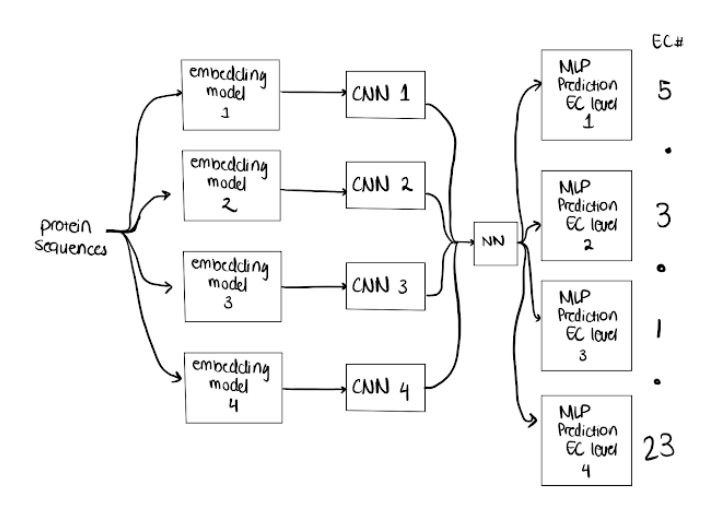

## GitHub Repository for Project

Our repository containing all data & preprocessing code is located here: 
[NLP for Protein Sequence to EC Number Prediction](https://github.com/tomastokar/MIE1517_nlp_proteins)

The initial dataset with ~60,000 sequences is located [HERE](https://github.com/tomastokar/MIE1517_nlp_proteins/blob/main/data/raw.csv)

This dataset was processed using [CD-HIT](http://weizhong-lab.ucsd.edu/cd-hit/) to remove protein sequence with > 80% similarity, leaving us with a dataset of ~17,000 proteins, which can be found [HERE](https://github.com/tomastokar/MIE1517_nlp_proteins/blob/main/data/postprocessedECnumToSeq-edited.csv)


*   The preprocessing of the data can be found in [THIS FILE](https://github.com/tomastokar/MIE1517_nlp_proteins/blob/main/codes/sequence-EC_analysis.py)
*   Preprocessing demonstrated that the preprocessed and postprocessed data has the same distribution of EC number levels, which is great

**Pre-processed Dataset**
<br/>
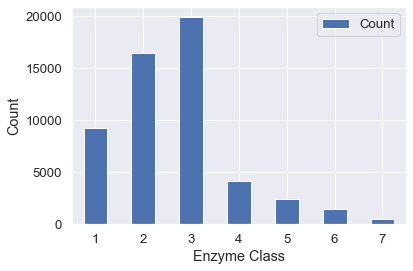


**Post-processed Dataset**
<br>
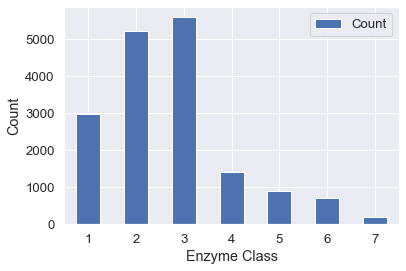


This is the data that we are using in this notebook and in the final project architechture as well 



In [ ]:
!pip install tape_proteins

In [ ]:
import torch
from tape import ProteinBertModel, TAPETokenizer
model = ProteinBertModel.from_pretrained('bert-base')
tokenizer = TAPETokenizer(vocab='iupac')

100%|██████████| 370264230/370264230 [00:32<00:00, 11497905.13B/s]


## Demonstrating TAPE Inputs, Outputs 

In [ ]:
sequence = 'GCTVEDRCLIGMGAILLNGCVIGSGSLVAAGALITQ'
token_ids = torch.tensor([tokenizer.encode(sequence)])
display(token_ids)
output = model(token_ids)
sequence_output = output[0]
pooled_output = output[1]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


tensor([[ 2, 11,  7, 23, 25,  9,  8, 21,  7, 15, 13, 11, 16, 11,  5, 13, 15, 15,
         17, 11,  7, 25, 13, 11, 22, 11, 22, 15, 25,  5,  5, 11,  5, 15, 13, 23,
         20,  3]])

In [ ]:
display(sequence_output[0].shape)
pooled_sequence_emb = torch.sum(sequence_output, dim=2)
display(pooled_sequence_emb.shape)
# display(pooled_output)

torch.Size([38, 768])

torch.Size([1, 38])

In [ ]:
display((pooled_output.shape), (sequence_output.shape))

torch.Size([1, 768])

torch.Size([1, 38, 768])

# Sequence Tokenization and Embedding Step

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv
file_dir = '/content/drive/My Drive/Colab Notebooks/Protein Sequence Analysis/'

def get_data():
  return csv.reader(open(file_dir + 'raw_edited.csv'))

display(get_data())

for i, line in enumerate(get_data()):
  # print(line)
  if line[0] == '1.14.11.67':
    print(line[1], line[2], line[3], line[4], line[5])
    break

1 14 11 67 PRVQRLNELEAKTRVKLNFLDQIAKFWELQGSSLKIPMVERKALDLYTLHRIVQEEGGMEQTTKDRKWAKVANRMQYPSSKSVGATLKAHYERILHPFEVYTSGKVL


In [ ]:
from pathlib import Path
from torch.utils import data as data
from tape import datasets
from tape import TAPETokenizer
from tape import ProteinBertForMaskedLM
from Bio import SeqIO
from tqdm.auto import tqdm
import pickle

data_folder = Path(file_dir)
input_sequence_fasta = 'raw.fasta'
batch_size = 100 

output_file_name_header = 'resultsoutput_'

Defining a loader 

In [ ]:
class LoaderClass(data.Dataset):
  def __init__(self, input_ids, attention_mask):
    super().__init__()
    self.input_ids = input_ids
    self.attention_mask = attention_mask
  
  def __len__(self):
    return self.input_ids.shape[0]
  
  def __getitem__(self, idx):
    return self.input_ids[idx], self.attention_mask[idx]

class Identity(nn.Module):
  def __init__(self):
    super(Identity, self).__init__()
  def forward(self, x, target=None):
    return (x,)

'embedding' function takes an input pretrained model (in this case, it is TAPE), data folder, the input sequence file, and the output file name for naming. This function takes the average of the values across the sequence length.

In [ ]:
def embedding(model, data_folder, input_sequence_file,output_file_name_header, batch_size=100):
  input_file = data_folder / input_sequence_file #data path (fasta)
  output_file = data_folder / (output_file_name_header + model + '.p') #output path (pickle)
  if model == 'TAPE':
    model = ProteinBertForMaskedLM.from_pretrained('bert-base')
  
    model.mlm = Identity()
    model.eval()
    embed = datasets.EmbedDataset(data_file=input_file, tokenizer='iupac')
    loader = data.DataLoader(embed, batch_size, False, collate_fn=embed.collate_fn)

    count_x = 0 
    model.cuda()

    seq_encodings = []
    seq_all_hiddens = []
    seq_ids = [] 

    for seq_batch in loader: ## Add .no_grad() here to see performance on GPU mem
      count_x += 1 
      print(count_x)
      ids, input_ids, input_mask = seq_batch["ids"], seq_batch["input_ids"], seq_batch["input_mask"]
      input_ids, input_mask = input_ids.cuda(), input_mask.cuda()
      with torch.no_grad():
        output = model(input_ids, input_mask)
      output = output[0].cpu().detach().numpy()
      features = []
      for seq_num in range(len(output)):
        seq_len = (input_mask[seq_num]==1).sum()
        seq_emd = output[seq_num][1:seq_len-1]
        seq_all_hiddens.append(seq_emd)
        features.append(np.mean(seq_emd, axis=0))
      features = np.stack(features)
      print('features.shape: ', features.shape)
      seq_encodings.append(features)
      seq_ids += ids
    seq_embeddings = np.concatenate(seq_encodings)
    print('seq_embeddings.shape: ', seq_embeddings.shape)
    seq_embedding_output = {"seq_embeddings":seq_embeddings, "seq_ids":seq_ids, "seq_all_hiddens":seq_all_hiddens}
    pickle.dump(seq_embedding_output, open(output_file, 'wb'))
    print('done')
  return seq_embedding_output

Defining input seqeuence data as fasta file and performing embedding. The embedding data is stored as a pickle file in the directory

In [ ]:
data_folder = Path(file_dir)
# input_sequence_fasta = 'postprocessedECnumtoSeq.fasta'
input_sequence_fasta = 'first500-80percent.fasta'
# input_sequence_fasta = 'raw.fasta'
# input_sequence_fasta = 'raw_first500.fasta'
batch_size = 10
output_file_name_header = 'resultsoutput_'

seq_embedding_output = embedding('TAPE', data_folder, input_sequence_fasta, output_file_name_header, batch_size)

Extracting the sequence embedding files from the directory

In [ ]:
## Get input files (embeddings from pickles)

embedding_file = 'resultsoutput_TAPE.p'

with open(data_folder / embedding_file, 'rb') as seqs_embeddings:
  seq_embeddings_pkl = pickle.load(seqs_embeddings)

X_seqs_embeddings_list = seq_embeddings_pkl['seq_embeddings']

print(X_seqs_embeddings_list.shape)

(500, 768)


Extracting ec number labels 

In [ ]:
import pandas as pd
EC_path = (file_dir + 'postprocessedECnumToSeq-edited.csv')
EC_sequence_data = pd.read_csv(EC_path)
EC_seq_data_500 = (EC_sequence_data.iloc[:500,2]).to_numpy()
display(EC_seq_data_500)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

Splitting the data into train, validation, and test sets

In [ ]:
from sklearn.model_selection import train_test_split 

X_training, X_test, y_training, y_test = train_test_split(X_seqs_embeddings_list, EC_seq_data_500, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.4)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(240, 768) (160, 768) (100, 768) (240,) (160,) (100,)


Defining a loader class again and data loaders for training, testing, and validation data

In [ ]:
class LoaderClass(data.Dataset):
  def __init__(self, embeding, label):
    super(LoaderClass, self).__init__()
    self.embedding = embeding
    self.label = label
  def __len__(self):
    return self.embedding.shape[0]
  def __getitem__(self,idx):
    return self.embedding[idx], self.label[idx]

In [ ]:
batch_size = 50
train_loader = data.DataLoader(LoaderClass(X_train, y_train), batch_size, True)
valid_loader = data.DataLoader(LoaderClass(X_val, y_val), batch_size, False)
test_loader = data.DataLoader(LoaderClass(X_test, y_test), batch_size, False)


Parameters for simple artifical neural network

In [ ]:
input_dimension = X_train.shape[1]
hidden_dimension = 2024
print(input_dimension)

768


In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleRNN, self).__init__()
        # self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        # x = self.emb(x)F
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

Tested MLP model

In [ ]:
from torch.nn.utils.weight_norm import weight_norm 
import torch.nn.functional as F

class MLP(nn.Module):
  def __init__(self, in_dim: int, hid_2: int):
    super(MLP,self).__init__()
    self.fc1 = weight_norm(nn.Linear(in_dim, hid_2), dim=None)
    self.dropout1 = nn.Dropout(p=0.0)
    self.fc2 = weight_norm(nn.Linear(hid_2, 4), dim=None)
  
  def forward(self, input):
    output = F.leaky_relu(self.fc1(input))
    output = self.dropout1(output)
    output = (self.fc2(output))
    return output

Training function

In [ ]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for sequences, labels in train:
            if use_cuda and torch.cuda.is_available():
              sequences=sequences.cuda()
              labels = labels.cuda()

            optimizer.zero_grad()
            pred = model(sequences)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def get_accuracy(model, data_loader):
  correct, total = 0, 0 
  for sequences, labels in data_loader:

    if use_cuda and torch.cuda.is_available():
      sequences = sequences.cuda()
      labels = labels.cuda()

    output = model(sequences)
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += labels.shape[0]
  return correct/total

# test_loader = test_loader
# get_accuracy = get_accuracy(model, test_loader)

CUDA is not available. Training on CPU...
Epoch 1; Loss 0.909080; Train Acc 0.687500; Val Acc 0.662500
Epoch 2; Loss 0.682047; Train Acc 0.745833; Val Acc 0.662500
Epoch 3; Loss 0.744162; Train Acc 0.770833; Val Acc 0.662500
Epoch 4; Loss 0.558027; Train Acc 0.762500; Val Acc 0.700000
Epoch 5; Loss 0.517377; Train Acc 0.837500; Val Acc 0.687500
Epoch 6; Loss 0.582454; Train Acc 0.829167; Val Acc 0.712500
Epoch 7; Loss 0.430683; Train Acc 0.845833; Val Acc 0.700000
Epoch 8; Loss 0.500123; Train Acc 0.854167; Val Acc 0.737500
Epoch 9; Loss 0.364061; Train Acc 0.883333; Val Acc 0.768750
Epoch 10; Loss 0.497769; Train Acc 0.879167; Val Acc 0.787500
Epoch 11; Loss 0.382015; Train Acc 0.879167; Val Acc 0.787500
Epoch 12; Loss 0.433054; Train Acc 0.895833; Val Acc 0.793750
Epoch 13; Loss 0.326962; Train Acc 0.912500; Val Acc 0.812500
Epoch 14; Loss 0.235739; Train Acc 0.916667; Val Acc 0.800000
Epoch 15; Loss 0.266147; Train Acc 0.929167; Val Acc 0.793750
Epoch 16; Loss 0.281336; Train Acc 0.

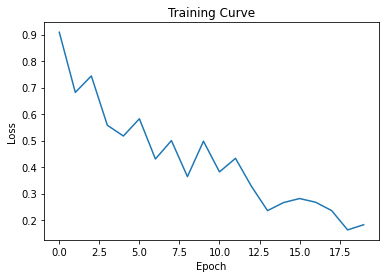

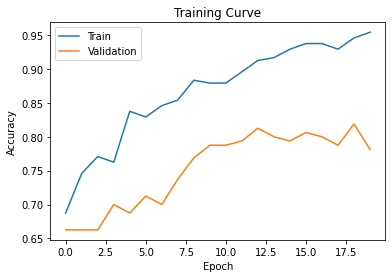

0.78

In [ ]:
use_cuda = False
model = MLP(in_dim=input_dimension, hid_2=hidden_dimension)

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available! Training on GPU...')
else:
  print('CUDA is not available. Training on CPU...')

train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-4)
get_accuracy(model, test_loader)

In [ ]:
%%shell
jupyter nbconvert --to html /content/TAPE_Test_Model.ipynb

[NbConvertApp] Converting notebook /content/TAPE_Test_Model.ipynb to html
[NbConvertApp] Writing 509926 bytes to /content/TAPE_Test_Model.html
